In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min=-100, x_max=100, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        real_low = (cumulative/cumulative.max()).min()
        real_high = (cumulative/cumulative.max()).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.uniform(low=real_low, high=real_high, size=pnts))
    return wrapper

In [3]:
# First trying sampling from a simple gaussian distribution
@inverse_sample_decorator
def gauss(x, amp=1.0, mean=0.0, std=0.2):
    return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [4]:
samples = gauss(5000, mean=20, std=0.8, x_min=19, x_max=21)

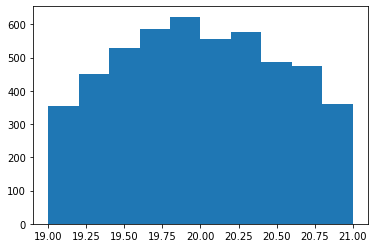

In [5]:
plt.hist(samples)
plt.show()

In [6]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4]):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

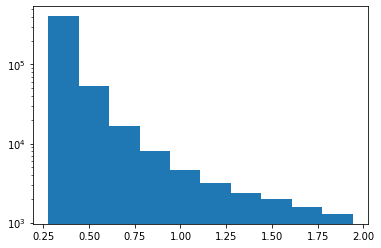

In [7]:
sampless = f(500000,ts=[1.1,1.2,1.3,1.4],x_min=1/(13**0.5),x_max=7/(13**0.5))

plt.hist(sampless, log=True)
plt.show()

[1.80216057 1.76831191 1.37027277 1.65395987]
[1.94329192 2.57211014 1.95659275 2.38500555]
[3.58166661 3.00129308 2.39133208 2.13757065]
[4.91777837 4.31106655 3.71110362 4.16420645]
[3.62529943 4.52971008 4.88720496 4.20598361]
[3.9004702  4.56392574 4.09667163 6.42934457]


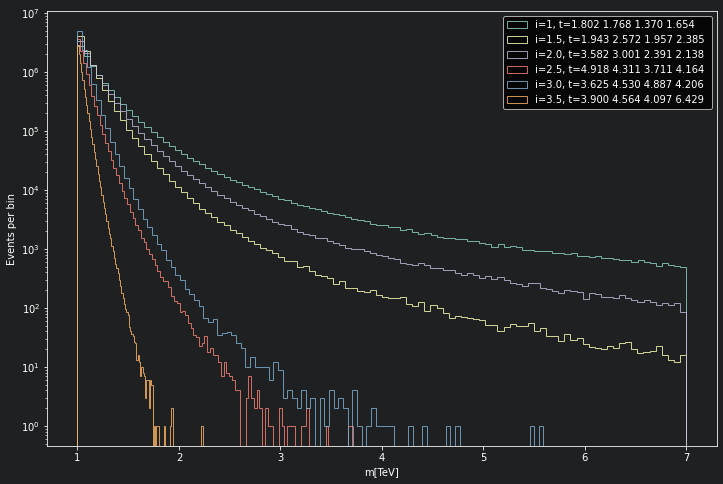

In [8]:
# Varing the theta values
# not sure the range that makes sense
plt.style.use("dark_background")
plt.figure(figsize=(12,8), facecolor='#1e2021')
ax = plt.gca()
ax.set_facecolor('#1e2021')
i = 1
while i != 4:
    tsx = i * np.random.uniform(low=1, high=2, size=4)
    print(tsx)
    strFormat = len(tsx) * '{:.3f} '
    ftsx = strFormat.format(*tsx)
    samplex = f(10000000,ts=tsx,x_min=1/(13**0.5),x_max=7/(13**0.5)) 
    samplex *= (13**0.5)
    plt.hist(samplex, log=True, label="i={}, t={}".format(i,ftsx), histtype="step",
             alpha=0.8, bins=100)
    i += 0.5
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [45]:
sampless = f(10000000,ts=[1.673,1.455,1.311,1.346],x_min=1/(13**0.5),x_max=7/(13**0.5))
sampless *= (13**0.5)

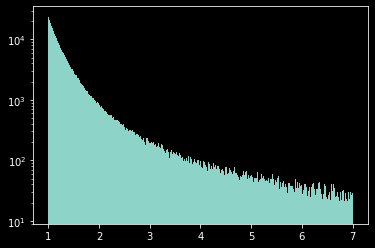

In [46]:
(n, bins, patches) = plt.hist(sampless, log=True, bins=10000)
plt.show()

In [52]:
# Now fit the histogram with NN
import tensorflow.keras as keras
# Create the model 
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=15, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_56 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 33,283
Trainable params: 33,283
Non-trainable params: 0
__________________________________________________

In [53]:
model.fit(bins[:n.shape[0]], n, epochs=100, verbose=1, batch_size=128, callbacks=callbacks)

Epoch 1/100
79/79 [==============================] - 0s 2ms/step - loss: 9631625.0000
Epoch 2/100
79/79 [==============================] - 0s 2ms/step - loss: 9328754.0000
Epoch 3/100
79/79 [==============================] - 0s 2ms/step - loss: 8669685.0000
Epoch 4/100
79/79 [==============================] - 0s 2ms/step - loss: 5874172.0000
Epoch 5/100
79/79 [==============================] - 0s 2ms/step - loss: 2499469.0000
Epoch 6/100
79/79 [==============================] - 0s 2ms/step - loss: 1107563.8750
Epoch 7/100
79/79 [==============================] - 0s 2ms/step - loss: 655141.6875
Epoch 8/100
79/79 [==============================] - 0s 2ms/step - loss: 475270.4062
Epoch 9/100
79/79 [==============================] - 0s 2ms/step - loss: 345273.5938
Epoch 10/100
79/79 [==============================] - 0s 2ms/step - loss: 258815.1094
Epoch 11/100
79/79 [==============================] - 0s 2ms/step - loss: 201143.3906
Epoch 12/100
79/79 [==============================] - 0s 

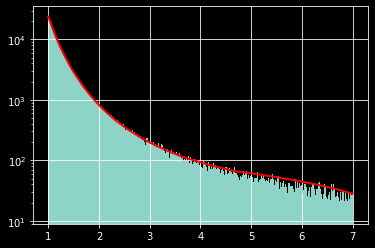

In [54]:
y_hat = model.predict(bins[:n.shape[0]])

# Display the result
plt.hist(sampless, log=True, bins=10000)
plt.plot(bins[:n.shape[0]], y_hat, 'r', linewidth=2)
plt.grid()
plt.show()

In [55]:
# Experimenting with QFL for monotonic
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
import tensorflow as tf

In [56]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 100

lattice_sizes = [5,4,3,2,2,2,3,4,5,6]
combined_calibrators = tfl.layers.ParallelCombination()

In [57]:
# ############### age ###############
#calibrator = tfl.layers.PWLCalibration(
#    # Every PWLCalibration layer must have keypoints of piecewise linear
#    # function specified. Easiest way to specify them is to uniformly cover
#    # entire input range by using numpy.linspace().
#    input_keypoints=np.linspace(
#        bins[:n.shape[0]].min(), bins[:n.shape[0]].max(), num=5),
#    # You need to ensure that input keypoints have same dtype as layer input.
#    # You can do it by setting dtype here or by providing keypoints in such
#    # format which will be converted to desired tf.dtype by default.
#    dtype=tf.float32,
#    # Output range must correspond to expected lattice input range.
#    output_min=0.0,
#    output_max=lattice_sizes[0] - 1.0,
#)
#combined_calibrators.append(calibrator)

In [58]:
lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
    1,1,1,1,1,1,1,1,1,1],
    output_min=n.min(),
    output_max=n.max())

In [59]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 10, activation = 'linear'))
#model.add(combined_calibrators)
model.add(lattice)
model.compile(loss='mse', optimizer="adam")

#model.build(features)
# Display the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_62 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_63 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 10)                650       
_________________________________________________________________
lattice_2 (Lattice)          (None, 1)               

In [60]:
#features = bins[:n.shape[0]].astype(np.float32)
#target = n.astype(np.float32)

In [61]:
model.fit(bins[:n.shape[0]], n, epochs=100, verbose=1, batch_size=128, callbacks=callbacks)

Epoch 1/100
79/79 [==============================] - 2s 20ms/step - loss: 7924723.0000
Epoch 2/100
79/79 [==============================] - 2s 20ms/step - loss: 2186707.7500
Epoch 3/100
79/79 [==============================] - 2s 20ms/step - loss: 890623.5625
Epoch 4/100
79/79 [==============================] - 2s 20ms/step - loss: 839390.9375
Epoch 5/100
79/79 [==============================] - 2s 20ms/step - loss: 831135.0000
Epoch 6/100
79/79 [==============================] - 2s 19ms/step - loss: 828657.8125
Epoch 7/100
79/79 [==============================] - 2s 20ms/step - loss: 828165.7500
Epoch 8/100
79/79 [==============================] - 2s 20ms/step - loss: 830282.5000
Epoch 9/100
79/79 [==============================] - 2s 19ms/step - loss: 830968.8750
Epoch 10/100
79/79 [==============================] - 2s 20ms/step - loss: 827310.6875
Epoch 11/100
79/79 [==============================] - 2s 20ms/step - loss: 828422.3750
Epoch 12/100
79/79 [==============================

79/79 [==============================] - 2s 20ms/step - loss: 162468.5312
Epoch 96/100
79/79 [==============================] - 2s 20ms/step - loss: 162369.4062
Epoch 97/100
79/79 [==============================] - 2s 20ms/step - loss: 173354.0156
Epoch 98/100
79/79 [==============================] - 2s 20ms/step - loss: 167295.5938
Epoch 99/100
79/79 [==============================] - 2s 20ms/step - loss: 161702.7188
Epoch 100/100
79/79 [==============================] - 2s 20ms/step - loss: 163852.6562


In [62]:
#model.evaluate(features, target)

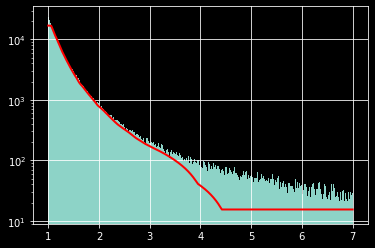

In [63]:
y_hat = model.predict(bins[:n.shape[0]])

# Display the result
plt.hist(sampless, log=True, bins=10000)
plt.plot(bins[:n.shape[0]], y_hat, 'r', linewidth=2)
plt.grid()
plt.show()